# Capstone Project: Face Mask Detection

## Introduction
Covid-19 was first discoverd in December 2019 and it has been 20 months since the pandemic and we have not seem any significant improvements in the number of cases and number of deaths globally. [As of today](https://www.worldometers.info/coronavirus/) there has been over 4.25 million deaths across the world. This is an ongoing fight amongst countries to collectively reduce the number of cases and deaths and eventually eradicate the pandemic. 

In Singapore, the government had imposed tough regulations to combat Covid-19 and were successful to a large extent. We kept our death rate to one of the lowest in the world and significantly reduced the number of new cases each day. However, we have still have a couple of cases each day and in fact from July 2021 there was a sudden rise in the number of covid-19 cases again. 

The Health Science Authority of Singapore has decided to relook into some of the regulations that we have imposed currently. The data science team has been tasked into looking at how we can encourage people to practice wearing masks efficiently. 

Efficacy of wearing a mask depends on its proper usage. [Another study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7557398/) done on the people of Japan, where wearing masks is actually a cultural normality shows only 23.1% of those surveyed practising proper usage of masks. Wearing mask incorrectly provides room for particles to escape and this is detrimental to the people around you especially if you do have the virus.   


### Problem Statement: 
To build a face mask detector model that is able to identify if a person is wearing a mask or not and if a person is wearing a mask correctly and incorrectly. 

The present solution for this face mask detector is broken down into two parts: 

1. Image Classification: Mask/No Mask/Incorrect Mask Classifier
2. Object Detection: Face Detection

## Executive Summary 

As described earlier wearing a mask is not just important but wearing it correctly deems higher efficacy. 


This is a multi-class classfication problem i.e. Person not wearing a mask, wearing a mask correctly and wearing a mask incorrectly. 

The datasets are extracted from [MaskedFace-Net](https://github.com/cabani/MaskedFace-Net) for correct and incorrect masks and [Flickr-Faces-HQ Dataset(FFHQ)](https://github.com/NVlabs/ffhq-dataset) for not wearing mask.
More details on the datasets can be found in the EDA section. 


First steps was to conduct a brief data cleaning and EDA to understand the data better. 
Train dataset has 19500 images with 6500 images in each class.
Test has 19407 images.

Next, we move on to preparing and processing the data to feed into our models. To do so, the dataset is first converted into a tensorflow dataset. The purpose of this is essentially to take advantage of the tensorflow data api and to build input Pipelines easily. Images from the datasets are then decoded and resized and parsed into the Pipeline.

Next we feed our data into our models. The base analysis is conducted on 4 different models namely, MobileNetV2,InceptionV3, ResNet50V2 and Exception. 

Top layer was removed and replaced with own output layer for our image classification task and will output predictions for 3 layers. The best model was fine tuned using regularisation and re-training of entire model with layers unfrozen.

Our best model, the RestNet50V2 achieved overall --- accuracy and --- on test dataset.

To ensure that our model work, we have to test on unseen data. This consists of images taken from the web of people wearing/ not wearing mask from a certain range. This is done through Object Detection, where the bounding boxes identify the coordinates of the face and cast their predictions. The faces are then cropped and passed on to the image classifier which then determines if a person is wearing a mask correctly or not. 

As the purpose of this project is to build a model that is best able to predict if a person is wearing a mask or not and if the person is wearing a mask correctly, we will use a default Object Detection model, which is OpenCV's DNN using the SSD Model or the Single Shot Multi Box Detector Model. 

Based on images taken from the internet and our live webcam, we can see that the object detection model outputs predictions for all classes accurately.



## Import Libraries and Images from Drive

In [2]:
#import all libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.image import imread
%matplotlib inline

import tensorflow as tf
import os,json
from glob import glob 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception


from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths


import time
import cv2
import os
from google.colab.patches import cv2_imshow

from PIL import Image as im

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [4]:
#change working directory 
os.chdir("/content/MyDrive/MyDrive/Capstone/code")

In [5]:
#file path of dataset.zip
dataset_zip_path = 'file:/content/MyDrive/MyDrive/Capstone/data/dataset.zip'

In [6]:
test_zip_path = 'file:/content/MyDrive/MyDrive/Capstone/data/test_dataset.zip'

In [7]:
#unzip Dataset.zip
data_unzip = tf.keras.utils.get_file(fname='dataset_zip', origin=dataset_zip_path, extract=True)

13126729728/13126721828 [==============================] - 211s 0us/step


In [8]:
testdata_unzip = tf.keras.utils.get_file(fname='testdataset_zip', origin=test_zip_path, extract=True)


13364625408/13364623366 [==============================] - 213s 0us/step


In [9]:
!ls /root/.keras/datasets

dataset  dataset_zip  __MACOSX	test_dataset  testdataset_zip


In [10]:
#change directory from zipped file to unzipped images
dataset_path = os.path.join(os.path.dirname(data_unzip), 'dataset')
print(dataset_path)

/root/.keras/datasets/dataset


In [11]:
testdataset_path = os.path.join(os.path.dirname(testdata_unzip), 'test_dataset')
print(testdataset_path)

/root/.keras/datasets/test_dataset


## EDA and Data Preprocessing

In this section we will briefly look at the datasets and the type of images in the datasets.

Then we will proceed to train-test-split and preprocess our data to store into data pipelines.

### Data Exploration

Some information regarding the datasets:

Incorrect Mask and Correct Mask Images
No Mask Images

- 1024 x 1024 pixels 
- Total of 65432 images across all classes 
- No Mask: 23503
- Correct Mask: 24027
- Incorrect Mask: 24596

In [12]:
#total number of images in dataset
len(glob(os.path.join(dataset_path, '*', '*')))

19886

In [13]:
print(len(glob(os.path.join(dataset_path, 'correct_mask', '*'))))
print(len(glob(os.path.join(dataset_path, 'incorrect_mask', '*'))))
print(len(glob(os.path.join(dataset_path, 'no_mask', '*'))))

6522
6740
6624


In [14]:
print(len(glob(os.path.join(testdataset_path, '*'))))

19407


In [15]:
pathlist = glob(os.path.join(dataset_path, '*', '*'))

In [16]:
testpathlist = glob(os.path.join(testdataset_path, '*'))

In [17]:
#store in dataframe
dataset_df = pd.DataFrame(pathlist)
dataset_df.rename(columns = {0 : 'imgpath'}, inplace = True)

In [18]:
class_list = []
imgname_list = []
for index,row in dataset_df.iterrows():
  class_list.append(row['imgpath'].split('/')[-2])
  imgname_list.append(row['imgpath'].split('/')[-1])

In [19]:
dataset_df['img'] = imgname_list
dataset_df['class'] = class_list

In [20]:
display(dataset_df.head())
display(dataset_df['class'].unique())

,imgpath,img,class
0,/root/.keras/datasets/dataset/correct_mask/004...,00443_Mask.jpg,correct_mask
1,/root/.keras/datasets/dataset/correct_mask/015...,01550_Mask.jpg,correct_mask
2,/root/.keras/datasets/dataset/correct_mask/047...,04720_Mask.jpg,correct_mask
3,/root/.keras/datasets/dataset/correct_mask/051...,05105_Mask.jpg,correct_mask
4,/root/.keras/datasets/dataset/correct_mask/033...,03376_Mask.jpg,correct_mask


array(['correct_mask', 'no_mask', 'incorrect_mask'], dtype=object)

In [21]:
classes = sorted(os.listdir(dataset_path))
classes.remove('.DS_Store')
classes

['correct_mask', 'incorrect_mask', 'no_mask']

View random image from each class

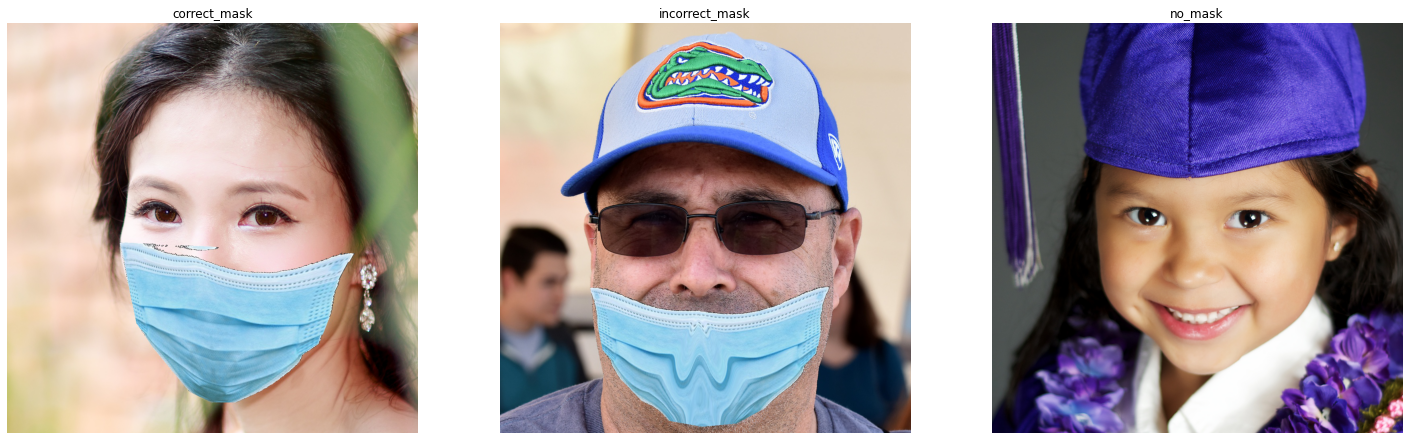

In [21]:
plt.figure(figsize=(25,15))

for i, class_ in enumerate(classes):
    ax = plt.subplot(1, 3, i + 1)
    imgpath = glob(os.path.join(dataset_path, class_, '*'))[np.random.randint(1, 1001)]
    image = imread(imgpath)
    plt.imshow(image)
    plt.title(f'{class_}')
    plt.axis('off')

## Modelling (Image Classification)

Research has shown that the training the DNN module from OpenCV on the SSD model along with the MobileNetV2 model are known to be ideal for Object Detection Classifications. We know for a fact that this combination will perform well. However, the purpose of this project is to find the _best_ model that will help identify if a person is wearing a mask correctly or not. Hence we will use this as a basis of comparison with other models. 

Before we dive into the various models. We will have to prepare our dataset for modelling first.

### Data Preparation and Pipeline

Create tensorflow dataset from current dataset and randomly split data set into train and validation set. 

Data will be split into 80% and 20% respectively.

In [22]:
#tensorflow dataset
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 128,
    image_size = (224, 224),
    shuffle = True,
    seed = 42,
    validation_split = 0.25,
    subset = 'training'
)


val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 128,
    image_size = (224, 224),
    shuffle = True,
    seed = 42,
    validation_split = 0.25,
    subset='validation'
)

Found 19886 files belonging to 3 classes.
Using 14915 files for training.
Found 19886 files belonging to 3 classes.
Using 4971 files for validation.


In [23]:
#store in dataframe
train_df = pd.DataFrame(train.file_paths)
val_df = pd.DataFrame(val.file_paths)

train_df.rename(columns = {0 : 'imgpath'}, inplace = True)
val_df.rename(columns = {0 : 'imgpath'}, inplace = True)

In [24]:
def add_class(df):
  class_list = []
  imgname_list = []
  for index,row in df.iterrows():
    class_list.append(row['imgpath'].split('/')[-2])
    imgname_list.append(row['imgpath'].split('/')[-1])
  
  df['img'] = imgname_list
  df['class'] = class_list

In [25]:
add_class(train_df)
add_class(val_df)

In [26]:
#one hot encode class names
train_df['classohe'] = train_df['class'].map(
    {'correct_mask': 0, 'incorrect_mask': 1, 'no_mask': 2})

val_df['classohe'] = val_df['class'].map(
    {'correct_mask': 0, 'incorrect_mask': 1, 'no_mask': 2})

In [27]:
#function to create pipeline for loading and resizing images 
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image_cast = tf.cast(image_decoded, tf.float32)
  image_resized = tf.image.resize(image_cast, [224, 224])
  label = tf.one_hot(label, 3)
  return image_resized, label

In [28]:
#train filenames and class names
train_filename = tf.constant(train.file_paths)
train_classnames = tf.constant(train_df['classohe'].astype('int32').tolist())

#val filenames and class names
val_filename = tf.constant(val.file_paths)
val_classnames = tf.constant(val_df['classohe'].astype('int32').tolist())

In [74]:
val_classnames

<tf.Tensor: shape=(4971,), dtype=int32, numpy=array([2, 1, 0, ..., 0, 0, 2], dtype=int32)>

### Data Augmentation

The purpose of data augmentation is to increase the diversity of data and to improve prediction accuracy. We will use keras' random data augmentation technique to augment images only in the train dataset.

In [29]:
from tensorflow.keras import layers

#augment images in train dataset only
augmentation = Sequential([
	layers.experimental.preprocessing.RandomFlip("horizontal"),
	layers.experimental.preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
	  width_factor=(-0.05, -0.15)),
	layers.experimental.preprocessing.RandomRotation(0.3)
])

#pixel intensity rescaling 
rescale = Sequential([                   
	layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)
])

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train.file_paths, train_classnames))
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.map(lambda x,y: (augmentation(x),y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x,y: (rescale(x),y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [31]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filename, val_classnames))
valid_dataset = valid_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(128)
valid_dataset = valid_dataset.map(lambda x,y: (rescale(x),y), num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

batch size input tensor etc

In [32]:
input_tensor = Input(shape=(224, 224, 3))

### Checkpoints and callbacks

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [34]:
def checkpoint(model):
    filepath = '/content/MyDrive/MyDrive/Capstone/models/' + model + '_checkpoint.hdf5'
    return ModelCheckpoint(
        filepath,
        verbose=1,
        save_best_only=True,
        mode='auto'
    )

In [49]:
es = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=8,
    min_delta=0.001,
    restore_best_weights=True
)

In [55]:
#function to draw loss graph and accuracy 

def loss_accuracy(model_history, epochs, model_name):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc", color = "green")
  plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc")
  plt.title(model_name + "Loss and Accuracy Graph")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss/Accuracy")
  plt.legend();

### Test Data Preparation

In [59]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    testdataset_path,
    label_mode = None,
    color_mode = 'rgb',
    image_size = (224, 224),
    seed = 42,
    shuffle = False
)

Found 19407 files belonging to 1 classes.


In [60]:
#create df
test_df = pd.DataFrame(testpathlist)
test_df.rename(columns = {0 : 'imgpath'}, inplace = True)

In [61]:
#df to store all files names and classes
class_list = []
imgname_list = []
for index,row in test_df.iterrows():
    class_list.append(row['imgpath'].split('/')[-1].split(' ')[0])
    imgname_list.append(row['imgpath'].split('/')[-1])
  
test_df['img'] = imgname_list
test_df['class'] = class_list

In [62]:
test_df['classohe'] = test_df['class'].map(
    {'correct_mask': 0, 'incorrect_mask': 1, 'no_mask': 2})

#### MobileNetV2

In [110]:
#Instantiate Base Model where the head FC layers are not included
basemodel_mn = MobileNetV2(weights = "imagenet",
                        include_top = False, 
                        input_tensor=input_tensor)

In [111]:
model = basemodel_mn.output
model = Flatten(name = 'flatten')(model)
model = Dense(128, activation = 'relu')(model)
model = Dense(3, activation = 'softmax')(model)
mobilenet = Model(inputs=basemodel_mn.input, outputs=model)

In [112]:
#loop through layers in base model to freeze them and preserve weights
for layer in basemodel_mn.layers:
	layer.trainable = False

In [113]:
mobilenet.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [114]:
mobilenet.compile(loss= 'categorical_crossentropy',
                             optimizer= "Adam",
                             metrics=['accuracy'])

In [115]:
mobilenetcheckpoint = checkpoint('mobilenet')

In [116]:
mobilenethistory = mobilenet.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [mobilenetcheckpoint, es])

Epoch 1/25
117/117 [==============================] - 184s 2s/step - loss: 1.1545 - accuracy: 0.8906 - val_loss: 0.1078 - val_accuracy: 0.9644

Epoch 00001: val_loss improved from inf to 0.10778, saving model to /content/MyDrive/MyDrive/Capstone/models/mobilenet_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
117/117 [==============================] - 401s 3s/step - loss: 0.1192 - accuracy: 0.9618 - val_loss: 0.1015 - val_accuracy: 0.9660

Epoch 00002: val_loss improved from 0.10778 to 0.10153, saving model to /content/MyDrive/MyDrive/Capstone/models/mobilenet_checkpoint.hdf5
Epoch 3/25
117/117 [==============================] - 180s 2s/step - loss: 0.0959 - accuracy: 0.9680 - val_loss: 0.0810 - val_accuracy: 0.9753

Epoch 00003: val_loss improved from 0.10153 to 0.08104, saving model to /content/MyDrive/MyDrive/Capstone/models/mobilenet_checkpoint.hdf5
Epoch 4/25
117/117 [==============================] - 176s 1s/step - loss: 0.0822 - accuracy: 0.9713 - val_loss: 0.1169 - val_accuracy: 0.9602

Epoch 00004: val_loss did not improve from 0.08104
Epoch 5/25
117/117 [==============================] - 402s 3s/step - loss: 0.0642 - accuracy: 0.9779 - val_loss: 0.1292 - val_accuracy: 0.9582

Epoch 00005: val_loss did not improve from 0.08104
Epoch 6/25
117/117 [========================

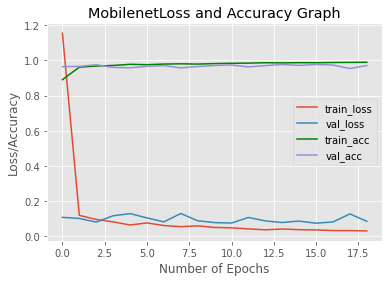

In [143]:
loss_accuracy(mobilenethistory, 19, "Mobilenet")

In [119]:
#Evaluate model on val data
score = mobilenet.evaluate(valid_dataset, verbose = 1)

39/39 [==============================] - 29s 713ms/step - loss: 0.0755 - accuracy: 0.9740


####InceptionV3

In [66]:
#Instantiate Base Model where the head FC layers are not included
basemodel_in = InceptionV3(weights = "imagenet",
                        include_top = False, 
                        input_tensor=input_tensor)

In [67]:
model = basemodel_in.output
model = Flatten(name = 'flatten')(model)
model = Dense(128, activation = 'relu')(model)
model = Dense(3, activation = 'softmax')(model)
inception_model = Model(inputs=basemodel_in.input, outputs=model)

In [68]:
#loop through layers in base model to freeze them and preserve weights
for layer in basemodel_in.layers:
	layer.trainable = False

In [69]:
inception_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [70]:
inceptioncheckpoint = checkpoint('inception')

In [71]:
inception_model.compile(loss= 'categorical_crossentropy',
                             optimizer= 'Adam',
                             metrics=['accuracy'])

In [72]:
inceptionhistory = inception_model.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [inceptioncheckpoint, es])

Epoch 1/25
117/117 [==============================] - 316s 3s/step - loss: 0.9516 - accuracy: 0.8507 - val_loss: 0.2357 - val_accuracy: 0.9081

Epoch 00001: val_loss improved from inf to 0.23568, saving model to /content/MyDrive/MyDrive/Capstone/models/inception_checkpoint.hdf5
Epoch 2/25
117/117 [==============================] - 455s 4s/step - loss: 0.1829 - accuracy: 0.9361 - val_loss: 0.1721 - val_accuracy: 0.9374

Epoch 00002: val_loss improved from 0.23568 to 0.17208, saving model to /content/MyDrive/MyDrive/Capstone/models/inception_checkpoint.hdf5
Epoch 3/25
117/117 [==============================] - 253s 2s/step - loss: 0.1486 - accuracy: 0.9474 - val_loss: 0.1439 - val_accuracy: 0.9477

Epoch 00003: val_loss improved from 0.17208 to 0.14390, saving model to /content/MyDrive/MyDrive/Capstone/models/inception_checkpoint.hdf5
Epoch 4/25
117/117 [==============================] - 219s 2s/step - loss: 0.1243 - accuracy: 0.9568 - val_loss: 0.1191 - val_accuracy: 0.9584

Epoch 00004

In [73]:
score = inception_model.evaluate(valid_dataset, verbose = 1)

39/39 [==============================] - 44s 1s/step - loss: 0.0747 - accuracy: 0.9732


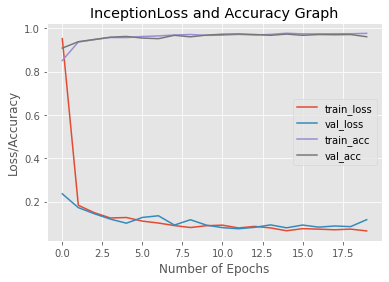

In [86]:
loss_accuracy(inceptionhistory, 20, "Inception")

#### ResNet50V2

In [144]:
#Instantiate Base Model where the head FC layers are not included
basemodel_rt = ResNet50V2(weights = "imagenet",
                        include_top = False, 
                        input_tensor=input_tensor)

94674944/94668760 [==============================] - 2s 0us/step


In [145]:
model = basemodel_rt.output
model = Flatten(name = 'flatten')(model)
model = Dense(128, activation = 'relu')(model)
model = Dense(3, activation = 'softmax')(model)
resnet = Model(inputs=basemodel_rt.input, outputs=model)

In [146]:
#loop through layers in base model to freeze them and preserve weights
for layer in basemodel_rt.layers:
	layer.trainable = False

In [147]:
resnet.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [149]:
resnet.compile(loss= 'categorical_crossentropy',
                             optimizer= 'Adam',
                             metrics=['accuracy'])

In [150]:
resnetcheckpoint = checkpoint('resnet')

In [ ]:
resnethistory = resnet.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [resnetcheckpoint, es])

In [ ]:
score = resnet.evaluate(valid_dataset, verbose = 1)

In [154]:
resnet_model = load_model('/content/MyDrive/MyDrive/Capstone/models/resnet_checkpoint.hdf5')

#### Xception

In [77]:
#Instantiate Base Model where the head FC layers are not included
basemodel_x = Xception(weights = "imagenet",
                        include_top = False, 
                        input_tensor=input_tensor)

83689472/83683744 [==============================] - 1s 0us/step


In [78]:
model = basemodel_x.output
model = Flatten(name = 'flatten')(model)
model = Dense(128, activation = 'relu')(model)
model = Dense(3, activation = 'softmax')(model)
xception_model = Model(inputs=basemodel_x.input, outputs=model)

In [79]:
#loop through layers in base model to freeze them and preserve weights
for layer in basemodel_x.layers:
	layer.trainable = False

In [80]:
xception_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [81]:
xception_model.compile(loss= 'categorical_crossentropy',
                             optimizer= 'Adam',
                             metrics=['accuracy'])

In [82]:
xceptioncheckpoint = checkpoint('xception')

In [83]:
xceptionhistory = xception_model.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [xceptioncheckpoint, es])

Epoch 1/25
117/117 [==============================] - 511s 4s/step - loss: 1.1328 - accuracy: 0.8740 - val_loss: 0.1788 - val_accuracy: 0.9491

Epoch 00001: val_loss improved from inf to 0.17877, saving model to /content/MyDrive/MyDrive/Capstone/models/xception_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
117/117 [==============================] - 506s 4s/step - loss: 0.2464 - accuracy: 0.9295 - val_loss: 0.2354 - val_accuracy: 0.9328

Epoch 00002: val_loss did not improve from 0.17877
Epoch 3/25
117/117 [==============================] - 309s 3s/step - loss: 0.2183 - accuracy: 0.9386 - val_loss: 0.2902 - val_accuracy: 0.9358

Epoch 00003: val_loss did not improve from 0.17877
Epoch 4/25
117/117 [==============================] - 315s 3s/step - loss: 0.2465 - accuracy: 0.9360 - val_loss: 0.2200 - val_accuracy: 0.9471

Epoch 00004: val_loss did not improve from 0.17877
Epoch 5/25
117/117 [==============================] - 313s 3s/step - loss: 0.1824 - accuracy: 0.9505 - val_loss: 0.1947 - val_accuracy: 0.9517

Epoch 00005: val_loss did not improve from 0.17877
Epoch 6/25
117/117 [==============================] - 311s 3s/step - loss: 0.1867 - accuracy: 0.9493 - val_loss: 0.2235 - val_accuracy: 0.9447

Epoch 00006: val_loss did not improve from 0.17877
Epoch 7/25
117/117 [=====

In [87]:
score = xception_model.evaluate(valid_dataset, verbose = 1)

39/39 [==============================] - 77s 2s/step - loss: 0.0728 - accuracy: 0.9771


In [ ]:
loss_accuracy(xceptionhistory, 20, "Xception ")

### Fine Tune Model

In [40]:
finetune_resnet = ResNet50V2(weights = "imagenet",
                        include_top = False, 
                        input_tensor=input_tensor)

94674944/94668760 [==============================] - 1s 0us/step


In [171]:
model = finetune_resnet.output
model = GlobalAveragePooling2D()(model)
model = Dense(128, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(3, activation = 'softmax')(model)
resnettuned = Model(inputs=finetune_resnet.input, outputs=model)

In [172]:
#loop through layers in base model to freeze them and preserve weights
for layer in finetune_resnet.layers:
	layer.trainable = False

In [173]:
resnettuned.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [174]:
resnettuned.compile(loss= 'categorical_crossentropy',
                             optimizer= "Adam",
                             metrics=['accuracy'])

In [47]:
restnettunedcheckpoint = checkpoint('resnettuned_finetuned')

In [176]:
resnettunedhistory = resnettuned.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [restnettunedcheckpoint, es])

Epoch 1/25
117/117 [==============================] - 284s 2s/step - loss: 0.3335 - accuracy: 0.8681 - val_loss: 0.0871 - val_accuracy: 0.9700

Epoch 00001: val_loss improved from inf to 0.08715, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
117/117 [==============================] - 269s 2s/step - loss: 0.1386 - accuracy: 0.9493 - val_loss: 0.0663 - val_accuracy: 0.9749

Epoch 00002: val_loss improved from 0.08715 to 0.06631, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5
Epoch 3/25
117/117 [==============================] - 275s 2s/step - loss: 0.1034 - accuracy: 0.9629 - val_loss: 0.0540 - val_accuracy: 0.9793

Epoch 00003: val_loss improved from 0.06631 to 0.05397, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5
Epoch 4/25
117/117 [==============================] - 275s 2s/step - loss: 0.0920 - accuracy: 0.9672 - val_loss: 0.0513 - val_accuracy: 0.9823

Epoch 00004: val_loss improved from 0.05397 to 0.05129, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5
Epoch 5/25
117/117 [==============================] - 278s 2s/step - loss: 0.0820 - accuracy: 0.9691 - val_loss: 0.

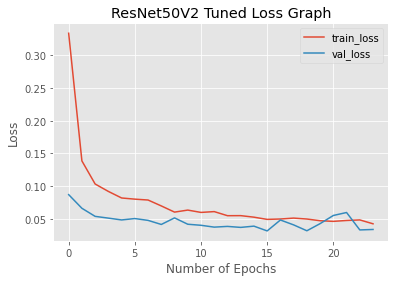

In [183]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 24), resnettunedhistory.history["loss"], label="train_loss")
plt.plot(np.arange(0, 24), resnettunedhistory.history["val_loss"], label="val_loss")
plt.title("ResNet50V2 Tuned Loss Graph")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend();

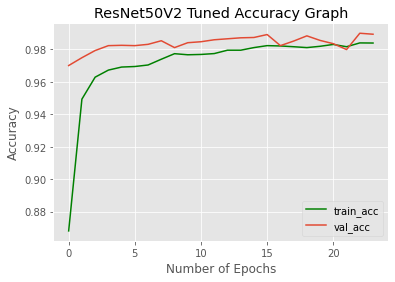

In [184]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 24), resnettunedhistory.history["accuracy"], label="train_acc", color = "green")
plt.plot(np.arange(0, 24), resnettunedhistory.history["val_accuracy"], label="val_acc")
plt.title("ResNet50V2 Tuned Accuracy Graph")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [42]:
model_reloaded = load_model('/content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5')

### Train Model End to End


In [43]:
#loop through layers in base model to freeze them and preserve weights
for layer in finetune_resnet.layers:
	layer.trainable = True

In [187]:
resnettuned.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#compile with lower learning rate
resnettuned.compile(loss= 'categorical_crossentropy',
                             optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                             metrics=['accuracy'])

In [50]:
model_reloadedhistory = model_reloaded.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = 25,
    callbacks = [restnettunedcheckpoint, es])

Epoch 1/25
117/117 [==============================] - 1016s 9s/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0255 - val_accuracy: 0.9938

Epoch 00001: val_loss improved from inf to 0.02550, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
117/117 [==============================] - 1057s 9s/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.0061 - val_accuracy: 0.9988

Epoch 00002: val_loss improved from 0.02550 to 0.00608, saving model to /content/MyDrive/MyDrive/Capstone/models/resnettuned_finetuned_checkpoint.hdf5
Epoch 3/25
117/117 [==============================] - 1044s 9s/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0110 - val_accuracy: 0.9978

Epoch 00003: val_loss did not improve from 0.00608
Epoch 4/25
117/117 [==============================] - 1035s 9s/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 0.0166 - val_accuracy: 0.9970

Epoch 00004: val_loss did not improve from 0.00608
Epoch 5/25
117/117 [==============================] - 1066s 9s/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0324 - val_accuracy: 0.9950

Epoch 00005: val_loss did not improve from 0.00608
Epoch 6/25
117/117 [==============================] - 1054s 9s/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.

In [51]:
score = model_reloaded.evaluate(valid_dataset, verbose = 1)

39/39 [==============================] - 61s 2s/step - loss: 0.0061 - accuracy: 0.9988


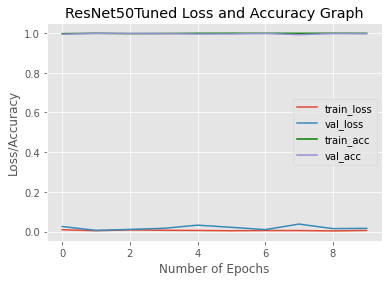

In [56]:
loss_accuracy(model_reloadedhistory, 10, "ResNet50Tuned ")


In [107]:
model_reloaded.save('/content/MyDrive/MyDrive/Capstone/models/final', save_format = 'h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Object Detection (Unseen Data)

Now that we have our final model, let us look at how this model performs on sample images of people not wearing mask, wearing masks or wearing them incorrectly. 

In [131]:
imgpath = '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages'

In [132]:
external_img = glob(os.path.join(imgpath, '*'))

In [133]:
external_img

['/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/sample.jpg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/ak_pcy_040821.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/nz_capture_180481.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/image.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/2d44075e-40ac-11ea-9fd9-ecfbb38a9743_image_hires_112302.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/44996_Mask_Chin.jpg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/http___com.ft.imagepublish.upp-prod-us.s3.amazonaws.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/2559.jpeg',
 '/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/1227809769.jpg.0.jpg']

In [103]:
from tensorflow.keras.applications.resnet50 import preprocess_input

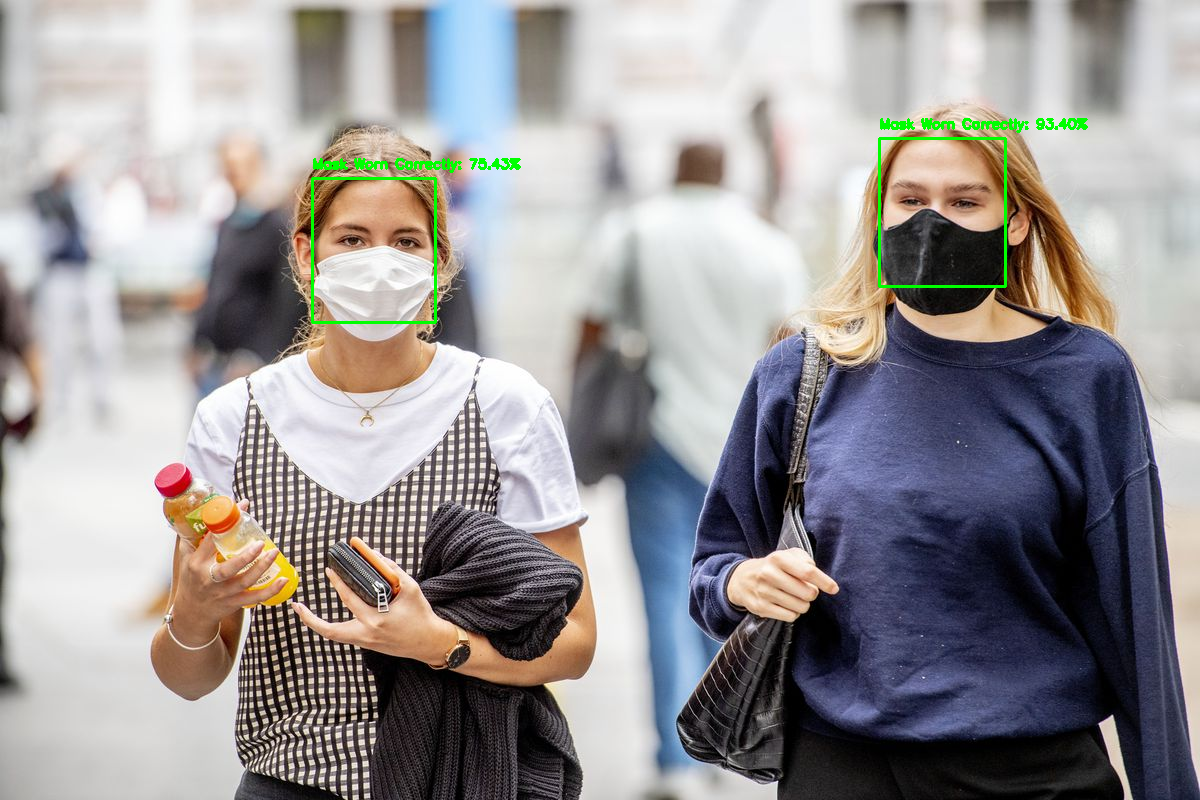

-1

In [134]:

#load_models
# load our serialized face detector model from disk
face_model = cv2.dnn.readNet('/content/MyDrive/MyDrive/Capstone/face_detection/deploy.prototxt', 
                             '/content/MyDrive/MyDrive/Capstone/face_detection/res10_300x300_ssd_iter_140000.caffemodel')

# load the face mask detector model from disk
mask_model = load_model('/content/MyDrive/MyDrive/Capstone/models/final')

#sample image
#read sample and get height and width
image = cv2.imread('/content/MyDrive/MyDrive/Capstone/face_detection/externalimages/1227809769.jpg.0.jpg')
copy = image.copy()
(h, w) = image.shape[:2]


blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
face_model.setInput(blob)
detections = face_model.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with the detection
  confidence = detections[0, 0, i, 2]

  # filter out weak detections by ensuring the confidence is greater than the minimum confidence
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    
    # ensure the bounding boxes fall within the dimensions of the frame
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    
    # extract the face ROI, convert it from BGR(OpenCV) to RGB(TensorFlow) channel ordering, resize to 224x224, convert to array and preprocess it
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis = 0)

    predictions = mask_model.predict(face)[0]
    
    #dictionary for the 3 labels (mask, incorrectmask, no_mask
    label = {
    0: {"name": "Mask Worn Correctly", "color": (0,255,0), "id": 0},
    1: {"name": "Mask Worn Incorrectly", "color": (255, 0, 0), "id": 1},
    2: {"name": "No Mask Worn", "color": (0, 0, 255), "id": 2} 
    }

    pred = np.argmax(predictions)
    
    # determine the class label and color we'll use to draw
		# the bounding box and text
    result = label[pred]["name"]
    color = label[pred]["color"]

    result = "{}: {:.2f}%".format(result, max(predictions) * 100)

        # display the label and bounding box rectangle on the output frame
    cv2.putText(image, result, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
 
cv2_imshow(image)
cv2.waitKey(0)


## Limitations

Theses models are trained on artificial datasets which are not accurate for real life mask predictions.

## Conclusion and Recommendations

In summary, the purpose of this project was to identify the best model in our multi class classification. From all the models tested, the [] model turned out to be the best model with the following parameters and hyperparameters.


Recommendations:
Now that we have an effective image classification and object detection model. The Health Sciences Authority could implement using the methods.

- Implement with Face Recoginition Thermal/Temperature Scanners
- Applications to be used for entry to public spaces

Further Improvements:
- This model is only effective at detecting people wearing mask at close range
- Does not generalise well to CCTV footage type images/videos for monitoring --> train on a different dataset


